# ESFS example workflow - Early human embryo scRNA-sequencing data
In this workflow we apply ESFS to early human embryo scRNA-sequencing data. We show that ESFS allows us to identify high resolution trajectories of cell fate decisions during the early stages of human embryo development in an unsupervised manner, simply by subsetting the data to genes identified by ESDS to be informative of cell state. Further, the ESFS workflow is able to dramatically improve data interprobility without needing to transform or impute that data through techniques such as PCA or data smoothing, thus mitigating the liklihood of introducing computational artefacts.


In [1]:
### Data path
path = "/Users/radleya/The Francis Crick Dropbox/BriscoeJ/Radleya/ESFS_Paper/Paper_Submission/Data/Peri_implantation_Human_Embryo_Example/"

In [2]:
from IPython.display import Image, display
display(Image(filename=path+"Workflow_Image.png"))

### Import ESFS package

In [3]:
import esfs

/opt/anaconda3/envs/ESFS_Env/lib/python3.11/site-packages/esfs/backend.py:45: UserWarning: CuPy is not installed. ESFS will run on CPU, which may be slower for large datasets.
  warnings.warn(


### Import additional packages

In [4]:
import plotly.express as px
from scipy.sparse import csc_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import FuncNorm
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import scanpy as sc
import anndata as ad
import umap

### Set python default discrete class colour palette to one with more colours

In [5]:
Colours = px.colors.qualitative.Dark24
Colours.remove('#222A2A') # Remove black form the color palette (personal preference).
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=Colours)


### Load early human embryo scRNA-seq data and sample info

In [6]:
adata = ad.read_h5ad(path+"ES_adata.h5ad")

### Basic quality control
With the origionally compiled data we performed basic counts normalisation and scaling with the below functions.

The motivation behind this normalisation was to reduce differences in sequencing depth/batch effects between samples
from different datasets.

In this workflow we have loaded the normalised data directly, so skip these lines, but leave them here for prosperity.

In [ ]:
# sc.pp.normalize_total(adata,target_sum=1e4,exclude_highly_expressed=True)
# sc.pp.scale(adata, max_value=10, zero_center=False)

### Create and save a scaled version of the scRNA-seq counts matrix
Create and save a scaled version of the scRNA-seq counts matrix where each genes has their observed expression values clipped if above a percentile threshold (default=97.5) and are then normalised by their maximum values so that all values are between 0-1, which is a requirment for the Entropy Sort Score (ESS) and Error Potential (EP) calcualtions.

In [8]:
adata = esfs.create_scaled_matrix(adata)

### Calculate ESS and EP matricies
Here we use the theory of Entropy Sorting to generate a pairwise gene correlation matrix (ESS matrix) and a correlation significance matrix (EP matrix). To speed up calculations parallel processing is implemented. To control the number of cores used for processing, vary the "Use_Cores" parameter which deaults to "Use_Cores=-1" which indicates the software will use n-1 cores, where n is the number of cores available on your machine. 
Please note that "Use_Cores=-1" is as special flag and "Use_Cores=-2" will not use n-2 cores. You should instead change "Use_Cores" to positive integer values of the number of cores you would like to use.

In [12]:
adata = esfs.parallel_calc_es_matrices(adata, secondary_features_label="Self", save_matrices=np.array(["ESSs","EPs"]), use_cores=-1)

Cores Available: 16
Cores Used: 15
Calculating ESS and EP matricies.
If progress bar freezes consider increasing system memory or reducing number of cores used with the 'use_cores' parameter as you may have hit a memory ceiling for your machine.


100%|██████████| 16633/16633 [17:37<00:00, 15.73it/s]


ESSs for Self label have been saved to 'adata.varm['Self_ESSs']'
EPs for Self label have been saved to 'adata.varm['Self_EPs']'


### Remove potential batch effect genes 
The early human embryo data used in this example contains samples from multiple datasets/labs. A common step for improving donwstream data interprobility of scRNA-seq data is to apply batch correction methods such as data integration. However, these methods have the potential of introducing computational aretefacts and obsfucating or removing gene expression patterns of interest. As such, mitigating the requirement of batch correction methods such as data integration can improve downstream analysis.

In the ESFS workflow, we note that batch effects may simply be an over-representation of a set of genes in a specific dataset. As such, we find that simply removing genes that are enriched specifically in one dataset is sufficient to remove signficant batch effects from downstream analysis, without needing to smooth or augment the scRNA-seq counts matrix.

To acheive this, we use the "Parallel_Calc_ES_Matricies" ESFS function to calculate the ESSs and EPs for each gene with regards to the "Dataset" labels provided in the meta data.

In [ ]:

Secondary_Features_Label = "Dataset_Secondary_Features"
Leiden_Clusts_Secondary_Features = csc_matrix(pd.get_dummies(adata.obs['Dataset']).astype("f"))
adata.obsm[Secondary_Features_Label] = Leiden_Clusts_Secondary_Features

adata = esfs.parallel_calc_es_matrices(adata, secondary_features_label=Secondary_Features_Label, save_matrices=np.array(["ESSs","EPs","SGs"]), use_cores=-1)

Exclude_Batch_Effect_Genes = np.asarray(adata.var_names[np.where(adata.varm['Dataset_Secondary_Features_ESSs'] > 0.01)[0]])
Exclude_Batch_Effect_Genes.shape

You have provided a 'secondary_features_label', implying that in the anndata object there is a corresponding csc_sparse martix object with rows as samples and columns as features. Each feature will be used to calculate ES scores for each of the variables of the adata object
Cores Available: 16
Cores Used: 15
Calculating ESS and EP matricies.
If progress bar freezes consider increasing system memory or reducing number of cores used with the 'use_cores' parameter as you may have hit a memory ceiling for your machine.


100%|██████████| 8/8 [00:00<00:00, 13.54it/s]

ESSs for Dataset_Secondary_Features label have been saved to 'adata.varm['Dataset_Secondary_Features_ESSs']'
EPs for Dataset_Secondary_Features label have been saved to 'adata.varm['Dataset_Secondary_Features_EPs']'
SGs for Dataset_Secondary_Features label have been saved to 'adata.varm['Dataset_Secondary_Features_SGs']'


(10944,)

### Calculate gene importance rankings
We now calculate the gene importance weights and hence gene importance rankings for the remaining genes in the dataset. For further details see our manuscript.

In [46]:
### An array of known important genes for early human embryo development so that we may use them as a
# reference point for how genes are beign ranked/grouped. Replace these genes with those you are
# interested in in your data.
Known_Important_Genes = np.array(["NANOG","SOX17","GATA4","PDGFRA","PRSS3","SPIC"])

### Run the ES_Rank_Genes function while using "Exclude_Genes=Exclude_Batch_Effect_Genes" to exclude possible
# batch effect genes and "Known_Important_Genes=Known_Important_Genes" as reference point genes.
adata = esfs.ES_rank_genes(adata,known_important_genes=Known_Important_Genes,exclude_genes=Exclude_Batch_Effect_Genes)

Pruning ESS graph by removing genes with with low numbers of edges (min_edges = 5)
Starting genes = 16633
Remaining genes = 8152
Remaining genes = 7838
Remaining genes = 7814
Remaining genes = 7808
Remaining genes = 7806
Remaining genes = 7805
Remaining genes = 7804
Remaining genes = 7803
Calculating feature weights
Known inportant gene ranks:
      NANOG  SOX17  GATA4  PDGFRA  PRSS3  SPIC
Rank    NaN    NaN   1375     NaN    NaN   NaN
ESFS gene weights have been saved to 'adata.var['ESFS_Gene_Weights']'
ESFS gene ranks have been saved to 'adata.var['ES_Rank']'


### Visualise clustering of top ranked genes in a UMAP generated from their pairwise ESS scores

Visualising the ESS graph of the top 4000 ranked genes in a UMAP.
Clustering == 'hdbscan', set Clustering to an integer value for automated Kmeans clustering.
This function outputs the 'Top_ESS_Genes', 'Gene_Clust_Labels' and 'Gene_Embedding' objects in case users would like to investigate them further.


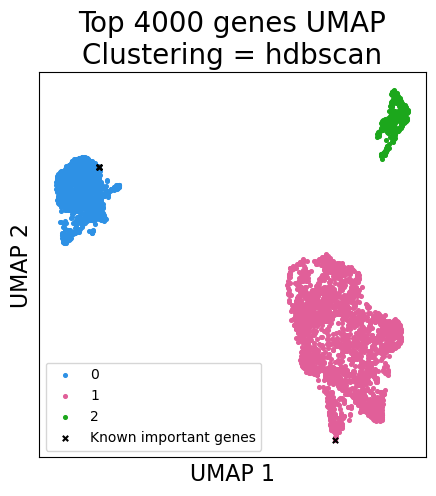

In [47]:
### Visualise top ranked genes graph
# Num_Top_Ranked_Genes is the second of the two paramaters that users should focus on when optimising
# the ESFS workflow for their data. Values between 3000-4000 are a typically good place to start.
Num_Top_Ranked_Genes = 4000

# The "Clustering" paramter can be set to an integer value if you wish to cluster genes in the UMAP with Kmeans clustering.
# Set "Clustering='hdbscan'" for automated density based clustering, and "Clustering=None" for no clustering.
Top_ESS_Genes, Gene_Clust_Labels, Gene_Embedding = esfs.plot_top_ranked_genes_UMAP(adata,Num_Top_Ranked_Genes,clustering="hdbscan",known_important_genes=Known_Important_Genes)
plt.show()

### Visualise the cell clustering UMAPs for each of the groupings of genes identified in the previous step

This is stage of the worfklow is a critical step for trying out different input parameters to try and optimise the final results. The 2 main paramters to vary are the "Num_Top_Ranked_Genes" and the "Clustering" inputs for the Plot_Top_Ranked_Genes_UMAP function.

In breif, you are seeking a gene cluster or combination of gene cluster that reveal biological structure of interest by excluding clusters of genes that contribute a large amount of noise to downstream analysis.

In [48]:
### Get the cell UMAPs for each cluster of genes identified via the Plot_Top_Ranked_Genes_UMAP function.
# n_neighbors: Number of nearest neighbours and min_dist paramaters used for each cell UMAP.
# log_transformed: Determines whether the counts matrix is log2 transcformed (True) or not (False) before generating UMAPs.
# metric: The distance metric used for cell UMAP creation. Default is "correlation" 
# and we highly recommend "correlation" or "cosine", but you may try others.
Gene_Cluster_Embeddings, Gene_Cluster_Selected_Genes = esfs.get_gene_cluster_cell_UMAPs(adata,Gene_Clust_Labels,Top_ESS_Genes,n_neighbors=50,min_dist=0.1,log_transformed=True)

Generating the cell UMAP embeddings for each cluster of genes from the previous function.
Plotting cell UMAP using gene cluster 0
Plotting cell UMAP using gene cluster 1
Plotting cell UMAP using gene cluster 2


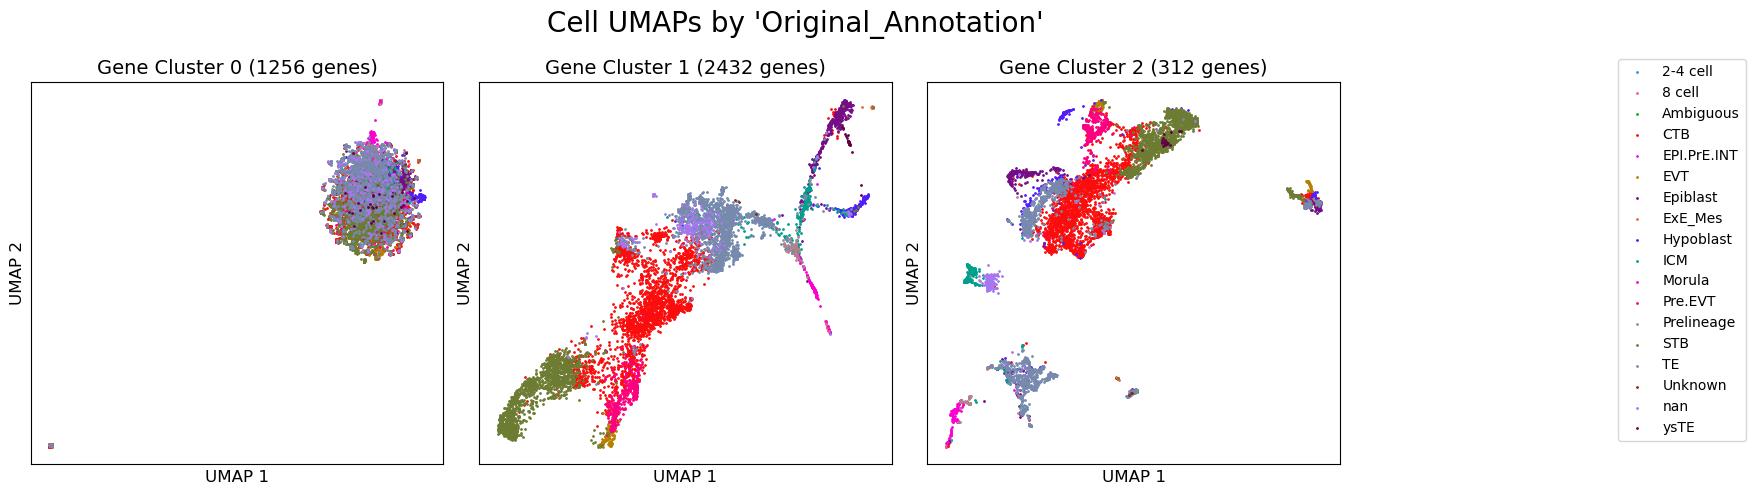

In [49]:
# Plot the cell UMAPs for each gene cluster.
esfs.plot_gene_cluster_cell_UMAPs(adata,Gene_Cluster_Embeddings,Gene_Cluster_Selected_Genes,cell_label="Original_Annotation",
    ncol=3,figsize=(16, 5),marker_size=1,log2_gene_expression=True)
plt.show()

/opt/anaconda3/envs/ESFS_Env/lib/python3.11/site-packages/esfs/plotting.py:450: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


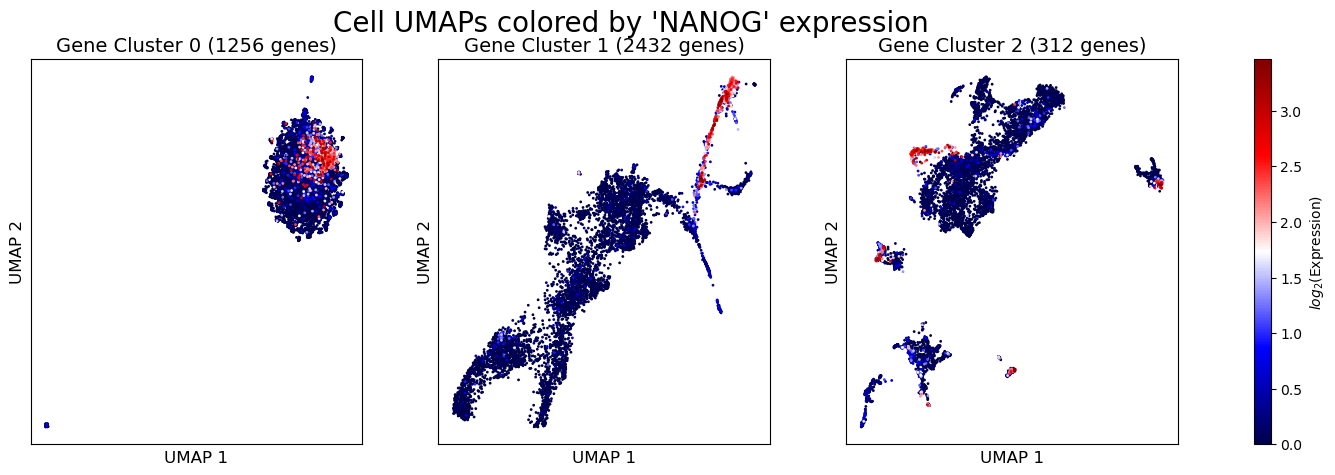

In [54]:
# Plot the cell UMAPs for each gene cluster.
esfs.plot_gene_cluster_cell_UMAPs(adata,Gene_Cluster_Embeddings,Gene_Cluster_Selected_Genes,cell_label="NANOG",
    ncol=3,figsize=(16, 5),marker_size=1,log2_gene_expression=True)
plt.show()

### If you'd like to generate the cell UMAP for a specific cluster of a combination or clusters, use the specific_cluster parameter

For this workflow we find cluster 1 to be produce the most distinct and informative UMAP, so we use "specific_cluster=[1]".

In [55]:
Gene_Cluster_Embeddings, Gene_Cluster_Selected_Genes = esfs.get_gene_cluster_cell_UMAPs(adata,Gene_Clust_Labels,Top_ESS_Genes,specific_cluster=[1],n_neighbors=50,min_dist=0.1,log_transformed=True)

Generating the cell UMAP embeddings for each cluster of genes from the previous function.
Plotting cell UMAP using gene cluster [1]


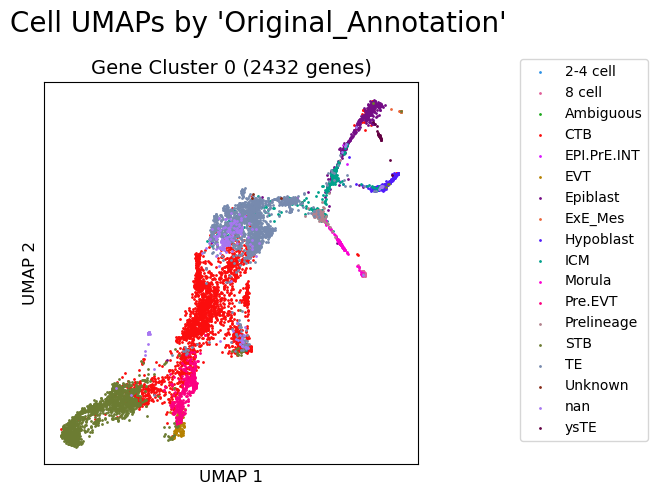

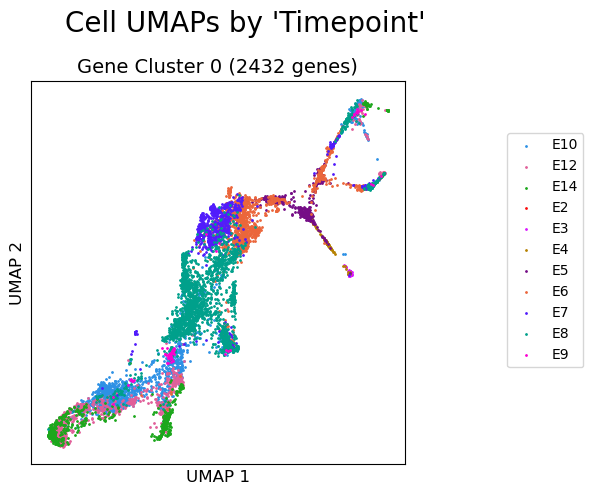

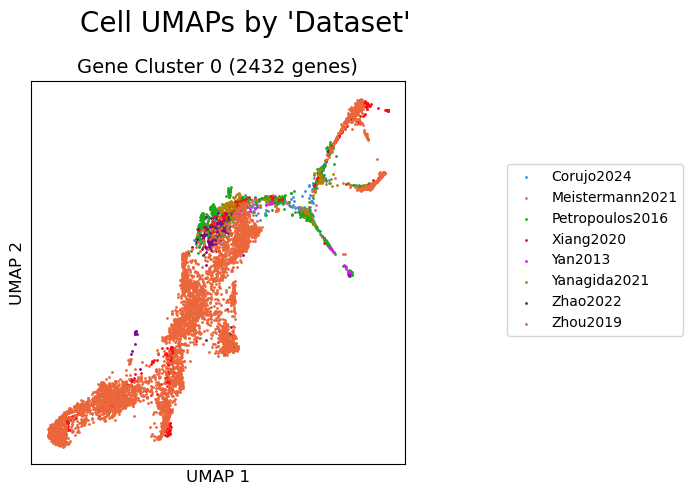

In [57]:
esfs.plot_gene_cluster_cell_UMAPs(adata,Gene_Cluster_Embeddings,Gene_Cluster_Selected_Genes,cell_label="Original_Annotation",
    ncol=1,figsize=(5, 5),marker_size=1,log2_gene_expression=True)

esfs.plot_gene_cluster_cell_UMAPs(adata,Gene_Cluster_Embeddings,Gene_Cluster_Selected_Genes,cell_label="Timepoint",
    ncol=1,figsize=(5, 5),marker_size=1,log2_gene_expression=True)

esfs.plot_gene_cluster_cell_UMAPs(adata,Gene_Cluster_Embeddings,Gene_Cluster_Selected_Genes,cell_label="Dataset",
    ncol=1,figsize=(5, 5),marker_size=1,log2_gene_expression=True)

In [58]:
# Retain ES-GSS selected genes and resuting cel UMAP embedding
ES_GSS_Genes = Gene_Cluster_Selected_Genes[0].copy()
ES_UMAP_Embedding = Gene_Cluster_Embeddings[0].copy()

### Store the UMAP embedding model
Typically for visualisation of a particular dataset, the UMAP embedding is retreived from the umap function. In our work we show that since ES-GSS allows us to find a set of genes that improves dataset interprobility in the gene expression space (without requireing dimensionality reduction or data de-noising). As such, the below code allows us to retain the UMAP model that a given UMAP embedding is derived from and then use that model to unbiasedly project query data into the reference data UMAP space.

A random state of 42 is used because that is the default for the Get_Gene_Cluster_Cell_UMAPs function.

/opt/anaconda3/envs/ESFS_Env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


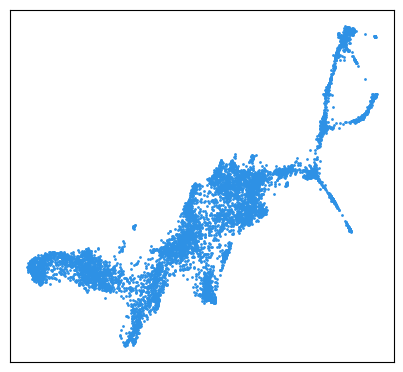

In [59]:
Embedding_Model = umap.UMAP(n_neighbors=50, metric="correlation",min_dist=0.1,n_components=2,random_state=42).fit(np.log2(adata[:,ES_GSS_Genes].X.toarray()+1))
# Saving over the previous ES_UMAP_Embedding to remove doubt, but the plot below confirms they are are same.
ES_UMAP_Embedding = Embedding_Model.embedding_

plt.figure(figsize=(4,4))
plt.scatter(ES_UMAP_Embedding[:,0],ES_UMAP_Embedding[:,1],s=1)
plt.xticks([])
plt.yticks([])
#
plt.subplots_adjust(0.02,0.02,0.98,0.9)
plt.show()


In [60]:
## For plotting, we often use the kNN smoothed expression. Using this function we can get the smoothed counts
# matrix according to the cell neighbourhoods in the gene expression space, sub-setted to the ES_GSS_Genes
adata = esfs.knn_smooth_gene_expression(adata, ES_GSS_Genes, knn=50, metric='correlation', log_scale=False)

Computing batched correlation distances for 7732 cells, batch size = 1000
Smoothing expression matrix using mean over 50 neighbors...


### ES Marker Gene Selection

Having identified a set of genes that improves cell type seperation, we will use the use the Entropy Sorting Combinatorial Cluster Finder (ES-CCF) and Entropy Sorting Find Marker Gene (ES-FMG) algorithms to find a small set of marker genes that are optimised to capture distinct cell states.

In [61]:
## First we subset the data to the ES_GMS_Genes genes and use the sc.pp.neighbors function to calculate the distance
# and neighbourhood arrays.
sub_adata = adata[:, ES_GSS_Genes].copy()
# Some Scanpy functions are slower on sparse matricies so we turn the sparse counts matrix into a dense one.
sub_adata.X = np.log2(sub_adata.X.toarray()+1)
# n_pcs is set to 0 so the gene expression counts are used rather than latent principal components.
sc.pp.neighbors(sub_adata, n_neighbors=50, n_pcs=0, metric="correlation")
# Obtain UMAP co-ordinates
sc.tl.umap(sub_adata,min_dist=0.1)

/var/folders/r9/cmjg8gtj47xd5r03cdvsq6wr0000gp/T/ipykernel_17378/741271042.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(sub_adata,resolution = 8)


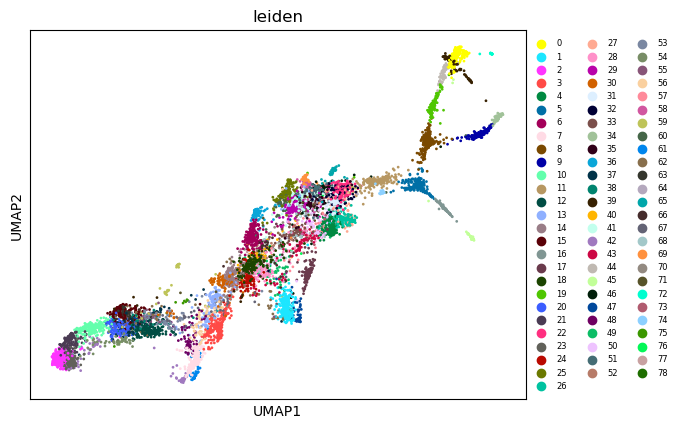

In [62]:
## Run leiden clustering with a relitively high resolution paramater to intentionally over-cluster the cells.
sc.tl.leiden(sub_adata,resolution = 8)
# Visualise the clustering
sc.pl.umap(sub_adata, color=['leiden'],legend_fontsize=6)

In [63]:
## Extract the cluster labels and add them to the adata object
Leiden_Clusts = np.asarray(sub_adata.obs['leiden'])
Unique_Leiden_Clusts = np.unique(Leiden_Clusts)
sample_labels = "Leiden_Clusts"
adata.obs[sample_labels] = Leiden_Clusts

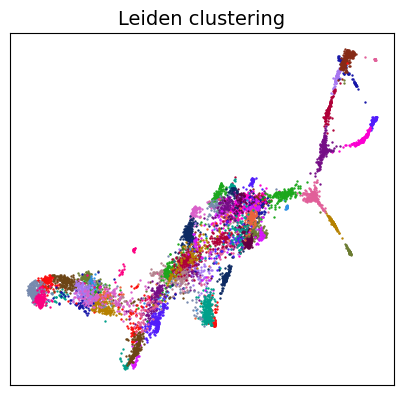

In [64]:
## Sometimes randomly shuffling the Unique_Leiden_Clusts IDs before plotting (to change cluster label colours)
# can help us better visualise the over-clustering.
Unique_Leiden_Clusts = np.unique(Leiden_Clusts)
np.random.shuffle(Unique_Leiden_Clusts)

plt.figure(figsize=(4,4))
plt.title("Leiden clustering",fontsize=14)
for i in np.arange(Unique_Leiden_Clusts.shape[0]):
    Inds = np.where(Leiden_Clusts == Unique_Leiden_Clusts[i])[0]
    plt.scatter(ES_UMAP_Embedding[Inds,0],ES_UMAP_Embedding[Inds,1],s=0.5)

plt.xticks([])
plt.yticks([]) 
#
plt.subplots_adjust(0.02,0.02,0.98,0.9)

# Re-set the Unique_Leiden_Clusts labels
Unique_Leiden_Clusts = np.unique(Leiden_Clusts)
plt.show()

Now we use the Leiden clusters as the input for ES-CCF to identify sets of samples/cells that maximise the correlation of each feature/gene in adata object.

By default the esfs.Parallel_Calc_ES_Matricies function calculates ES metrics of each feature in adata against each feature in adata (pairwise). However, esfs.Parallel_Calc_ES_Matricies may also be provided a set of "Secondary_Features", where each of these Secondary_Features will have ES metrics calculated pairwise against each feature in the adata object. Hence we refer to the Leiden cluster labels as secondary features.

In [65]:
# The Secondary_Features_Label will be used as a prefix to save resulting ES metrics to the adata object.
Secondary_Features_Label = "Leiden_Clusts_Secondary_Features"
# Using the pd.get_dummies function we convert the Leiden_Clusts vector into a one-hot representation where each 
# unique label becomes it's own feature of 0's and 1's.
Leiden_Clusts_Secondary_Features = csc_matrix(pd.get_dummies(Leiden_Clusts).astype("f"))
adata.obsm[Secondary_Features_Label] = Leiden_Clusts_Secondary_Features

We use Parallel_Calc_ES_Matricies to calculate the required metrics for ES combinatorial marker gene identification (save_matrices=np.array(["ESSs","SGs"])). 
Secondary_Features_Label designates a prefix for saving the ESS and SG outputs.

In [66]:
adata = esfs.parallel_calc_es_matrices(adata, secondary_features_label=Secondary_Features_Label, save_matrices=np.array(["ESSs","SGs"]), use_cores=-1)

You have provided a 'secondary_features_label', implying that in the anndata object there is a corresponding csc_sparse martix object with rows as samples and columns as features. Each feature will be used to calculate ES scores for each of the variables of the adata object
Cores Available: 16
Cores Used: 15
Calculating ESS and EP matricies.
If progress bar freezes consider increasing system memory or reducing number of cores used with the 'use_cores' parameter as you may have hit a memory ceiling for your machine.


100%|██████████| 79/79 [00:05<00:00, 13.26it/s]


ESSs for Leiden_Clusts_Secondary_Features label have been saved to 'adata.varm['Leiden_Clusts_Secondary_Features_ESSs']'
SGs for Leiden_Clusts_Secondary_Features label have been saved to 'adata.varm['Leiden_Clusts_Secondary_Features_SGs']'


With the ESS and SG matricies saved to adata, we can use the ES_CCF function to identify which combination of Leiden Clusters maximises the correlation (ESS) or each feature/gene in adata. The main output of ES_CCF is a 2D array where each row is the samples of adata and each column is a feature representing the identified combination of Leiden Clusters that maximises the ESS score of the respective feature/gene column in adata.

The ES_CCF function prints where the ES_CCF outputs are saved in the adata object.

In [67]:
adata = esfs.ES_CCF(adata,Secondary_Features_Label)

Cores Available: 16
Cores Used: 15
Calculating ESS and EP matricies.
If progress bar freezes consider increasing system memory or reducing number of cores used with the 'use_cores' parameter as you may have hit a memory ceiling for your machine.


100%|██████████| 16633/16633 [02:27<00:00, 113.11it/s]


Max combinatorial ESSs for given sample labels has been saved as 'adata.varm['Leiden_Clusts_Secondary_Features_Max_Combinatorial_ESSs']'
The features/clusters relating to each max_ESS have been saved in 'adata.obsm['Leiden_Clusts_Secondary_Features_Max_ESS_Features']'


#### Visualise Max ESS clusters
With the below script, you may select a gene and visualise the corresponding Max ESS cluster identified by the ES-CCF algorithm as maximally correlating/enriching the genes expression values in a group samples.

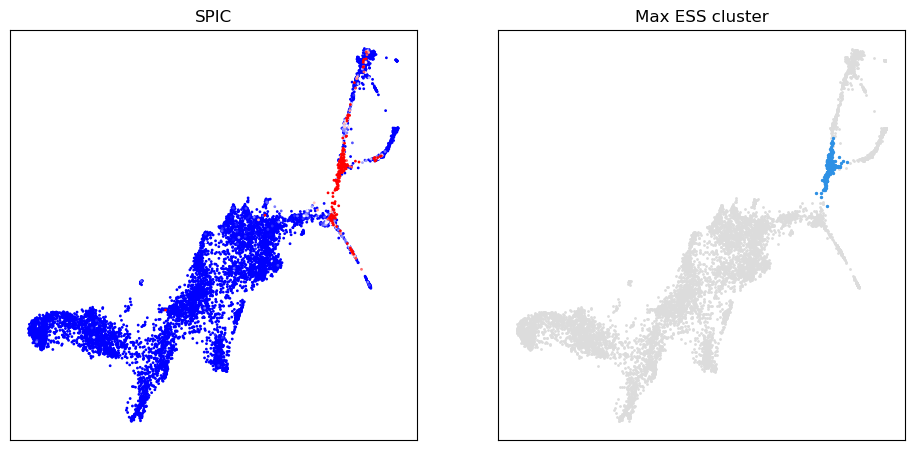

In [68]:
###
Gene = "SPIC" # "FGF2", "NODAL", "FOXA2", "AKR1B1", "JAM3"
###
Gene_Ind = np.where(adata.var_names == Gene)[0]
Inds = np.where(adata.obsm['Leiden_Clusts_Secondary_Features_Max_ESS_Features'][:,Gene_Ind].toarray() == 1)[0]
plt.figure(figsize=(4.66*2,2.33*2))
plt.subplot(1,2,1)
plt.title(Gene,fontsize=12)
Exp = np.asarray(adata[:,Gene].X.toarray()).ravel()
Exp = np.clip(Exp,a_min=0,a_max=np.percentile(Exp,97.5))
Order = np.argsort(Exp)
plt.scatter(ES_UMAP_Embedding[Order,0],ES_UMAP_Embedding[Order,1],c=Exp[Order],s=1,cmap="bwr")
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.title("Max ESS cluster",fontsize=12)
plt.scatter(ES_UMAP_Embedding[:,0],ES_UMAP_Embedding[:,1],s=1,c="gainsboro")
plt.scatter(ES_UMAP_Embedding[Inds,0],ES_UMAP_Embedding[Inds,1],s=2)
plt.xticks([])
plt.yticks([])
#
plt.subplots_adjust(0.02,0.02,0.98,0.9)

plt.show()

The 2D array of combined Leiden Clusters that maximise adata feature/gene ESSs is then used by Parallel_Calc_ES_Matricies as set of secondary features to obtain the ESS scores of each feature/gene in adata against each identified structure maximising feature. This creates a 2D pairwise adata feature/gene Vs coarse grain combined Leiden Cluster correlation matrix.

Plainly, we obtain a correlation matrix that quantifies how well each gene correlates to the ES-CCF optimised clusters for each gene. These correlations act as a proxy for where are best enriched in the combinatorial cluster space of the intentionally over-clustered data.

In [69]:
# Set the Leiden cluster Max ESS Features as the new secondary features
Secondary_Features_Label = "Leiden_Clusts_Secondary_Features_Max_ESS_Features"
adata = esfs.parallel_calc_es_matrices(adata, secondary_features_label=Secondary_Features_Label, save_matrices=np.array(["ESSs"]), use_cores=-1)

You have provided a 'secondary_features_label', implying that in the anndata object there is a corresponding csc_sparse martix object with rows as samples and columns as features. Each feature will be used to calculate ES scores for each of the variables of the adata object
Cores Available: 16
Cores Used: 15
Calculating ESS and EP matricies.
If progress bar freezes consider increasing system memory or reducing number of cores used with the 'use_cores' parameter as you may have hit a memory ceiling for your machine.


100%|██████████| 16633/16633 [11:31<00:00, 24.05it/s]


ESSs for Leiden_Clusts_Secondary_Features_Max_ESS_Features label have been saved to 'adata.varm['Leiden_Clusts_Secondary_Features_Max_ESS_Features_ESSs']'


### ES-FMG
Now that we have a coarse grain represenation of where gene structure is maximised in different regions of the data, we can use esfs.ES_FMG to identify a minimal set of clusters/genes that captures that most unique/non-overlapping structure in the data. This minimal gene set may be thought of as an optimised set of unsuperised marker genes.

In [70]:
Secondary_Features_Label
Num_Genes = 300
Chosen_Clusters, Chosen_Genes, Chosen_Pairwise_ESSs = esfs.ES_FMG(adata,Num_Genes,Secondary_Features_Label,resolution=1)

Cores Available: 16
Cores Used: 15
Current highest score: 4.351147417867928
Current highest score: 4.5738156072685445
Current highest score: 4.787369517047361
Current highest score: 4.9726480456797635
Current highest score: 5.139842720641912
Current highest score: 5.304602882101312
Current highest score: 5.462687550593335
Current highest score: 5.617425108653363
Current highest score: 5.768299137499272
Current highest score: 5.9172282964816825
Current highest score: 6.060247014448036
Current highest score: 6.1980463154326655
Current highest score: 6.329311543473348
Current highest score: 6.459632979537253
Current highest score: 6.605006111925768
Current highest score: 6.728213175157096
Current highest score: 6.8458900715064654
Current highest score: 6.958408237341066
Current highest score: 7.06653459577339
Current highest score: 7.17314094013639
Current highest score: 7.275774715188673
Current highest score: 7.373942016824209
Current highest score: 7.469510668541256
Current highest sco

ES-FMG produces 3 outputs:
 
Chosen_Genes - The optimised set of N marker genes.

Chosen_Clusters - The Max ESS cluster indicies. Subsetting all adata genes to the Chosen_Clusters inds should yeild the same output as Chosen_Genes (adata.var_names[Chosen_Clusters]).

Chosen_Pairwise_ESSs - A pairwise matrix of the Chosen genes and their ESSs with the corresponding Max ESS clusters. The diadonal of this matrix is the ESS of the given marker gene with its Max ESS cluster.

#### Data visualisation
Now that we have a set of optimised marker genes, we may visualise and interpret the results. Below is a simple script to visualise expression in the UMAP space for raw and kNN smoothed gene expression.

We recommend saving plots for each of the ES-FMG "Chosen_Genes" and inspecting them to visualise where the optimised set of marker genes capture different populations of samples.

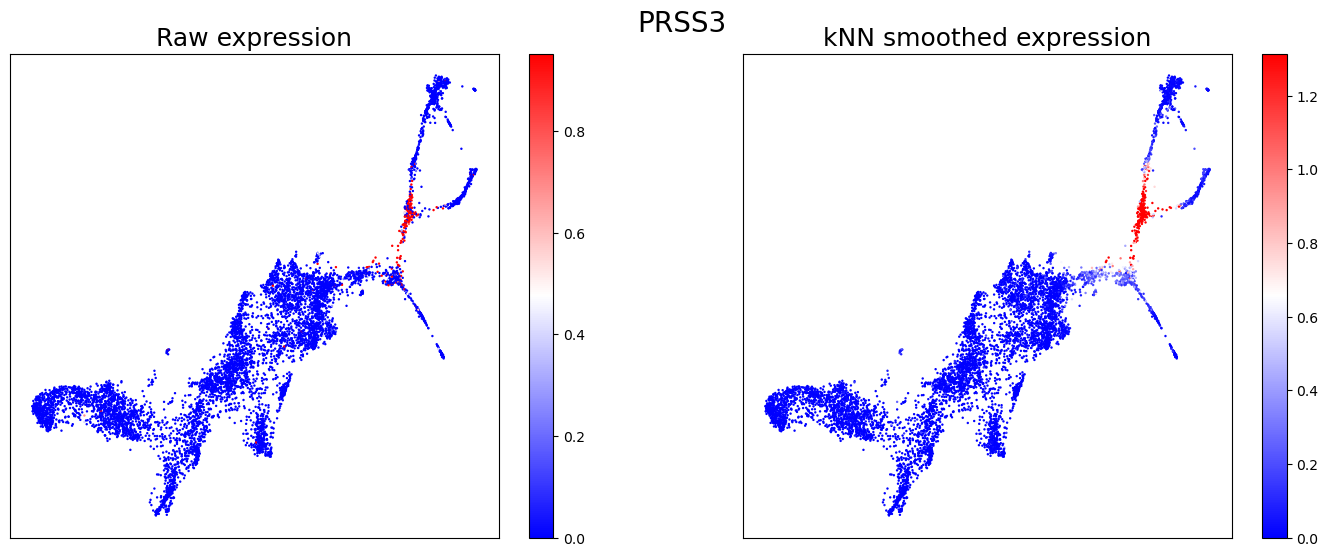

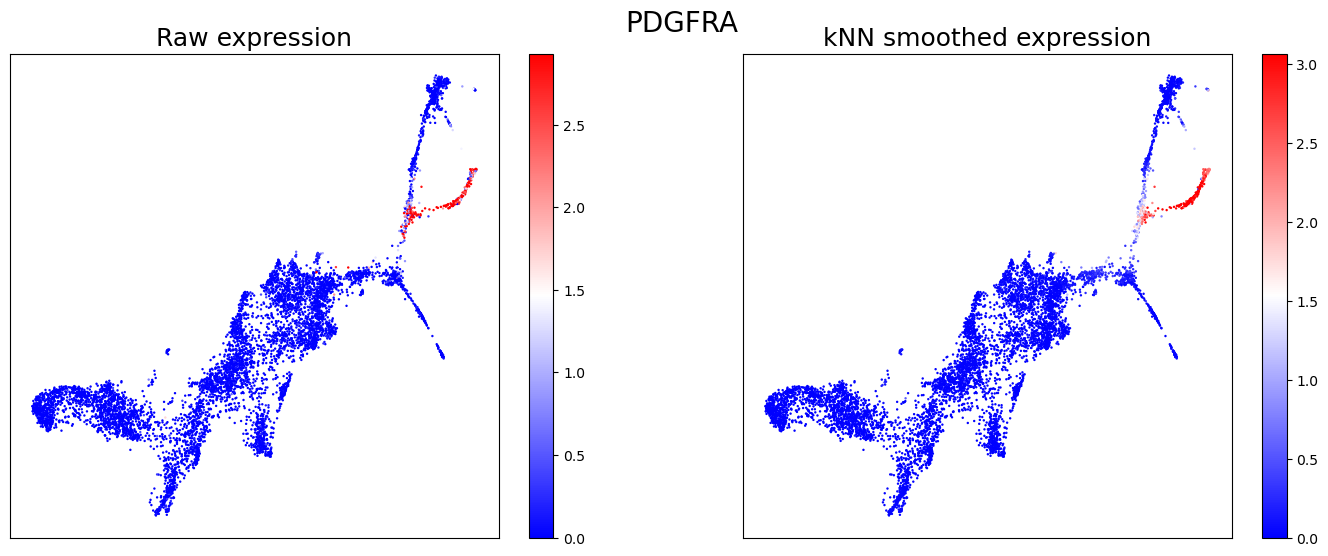

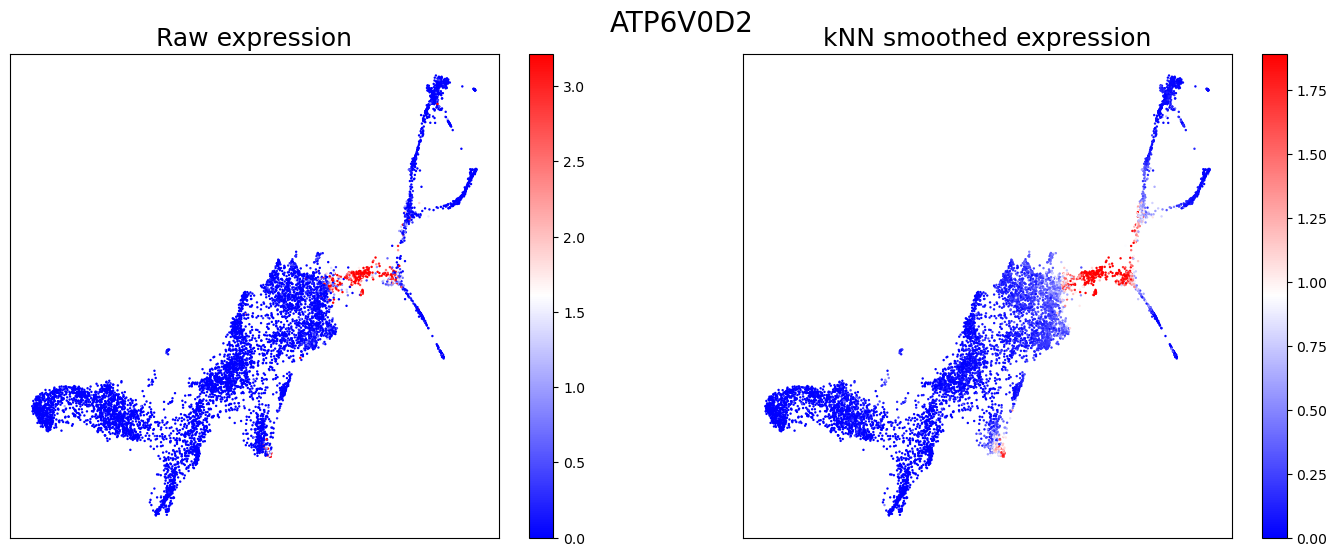

In [71]:
###
Plot_Genes = np.array(["PRSS3", "PDGFRA", "ATP6V0D2"])
###

###
# plot_save_path = "" Edit and uncomment to set the save path for plots
# Plot_Genes = Chosen_Genes.copy()
###

for i in np.arange(Plot_Genes.shape[0]):
    Gene = Plot_Genes[i]
    plt.figure(figsize=(14,5.5))
    plt.suptitle(Gene,fontsize=20)
    #
    plt.subplot(1,2,1)
    plt.title("Raw expression",fontsize=18)
    Exp = np.asarray(adata[:,Gene].X.toarray()).ravel()
    Exp = np.clip(Exp,a_min=0,a_max=np.percentile(Exp,97.5))
    Order = np.argsort(Exp)
    Order = np.arange(ES_UMAP_Embedding.shape[0])
    plt.scatter(ES_UMAP_Embedding[Order,0],ES_UMAP_Embedding[Order,1],c=Exp[Order],s=3,linewidths=0,cmap="bwr")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    #
    plt.subplot(1,2,2)
    plt.title("kNN smoothed expression",fontsize=18)
    Exp = np.asarray(adata[:,Gene].layers['Smoothed_Expression'].toarray()).ravel()
    Exp = np.clip(Exp,a_min=0,a_max=np.percentile(Exp,97.5))
    Order = np.argsort(Exp)
    Order = np.arange(ES_UMAP_Embedding.shape[0])
    plt.scatter(ES_UMAP_Embedding[Order,0],ES_UMAP_Embedding[Order,1],c=Exp[Order],s=3,linewidths=0,cmap="bwr")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    #
    plt.subplots_adjust(0.02,0.02,0.98,0.9)
    #
    # plt.savefig(plot_save_path + Gene + ".png",dpi=600)
    # plt.close()

plt.show()

### Projecting query data onto the UMAP embedding
Previously in the workflow we created the Embedding_Model object so that we may project query data onto the early embryo embedding.

Because this ESFS derived embedding was created directly from the gene expression space, projecting query data onto the embedding is relitively simple. We acheive this by subsetting a given query dataset to the genes used to create the UMAP embedding (namely, the ES_GSS_Genes gene set), and then apply the umap.transform() function to the query data.

#### Project West2019 CTB, STB and EVT scRNA-seq data

In [83]:
# Load query data
West2019_adata = ad.read_h5ad(path+"West2019.h5ad")
West2019_adata.obs_names_make_unique()

# Identify which ES_GSS_Genes genes are available in and which are missing the query data
Available_Genes = np.asarray(ES_GSS_Genes)[np.isin(ES_GSS_Genes,West2019_adata.var_names)]
Missing_Genes = np.asarray(ES_GSS_Genes)[np.isin(ES_GSS_Genes,West2019_adata.var_names)==0]

# Subset the query data to the available genes, and add new columns of zero values for the missing genes
Sub_West2019 = pd.concat([West2019_adata[:,Available_Genes].to_df(),pd.DataFrame(np.zeros((West2019_adata.shape[0],Missing_Genes.shape[0])),index=West2019_adata.obs.index,columns=Missing_Genes)],axis=1)

In [84]:
# Project the query sampls onto the embedding
West2019_Overlay = Embedding_Model.transform(np.log2(Sub_West2019[ES_GSS_Genes]+1))

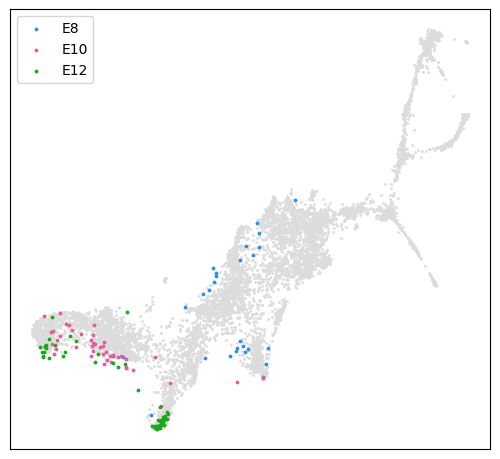

In [85]:
# Plot the results
plt.figure(figsize=(5,5))
#
plt.scatter(ES_UMAP_Embedding[:,0],ES_UMAP_Embedding[:,1],s=1,c="gainsboro")
#
E8_Inds = np.where(West2019_adata.obs["Timepoints"] == "E8")[0]
plt.scatter(West2019_Overlay[E8_Inds,0],West2019_Overlay[E8_Inds,1],s=3,label="E8")
E10_Inds = np.where(West2019_adata.obs["Timepoints"] == "E10")[0]
plt.scatter(West2019_Overlay[E10_Inds,0],West2019_Overlay[E10_Inds,1],s=3,label="E10")
E12_Inds = np.where(West2019_adata.obs["Timepoints"] == "E12")[0]
plt.scatter(West2019_Overlay[E12_Inds,0],West2019_Overlay[E12_Inds,1],s=3,label="E12")
#
plt.xticks([])
plt.yticks([])
plt.legend()
#
plt.subplots_adjust(0.02,0.02,0.98,0.9)
#
plt.show()

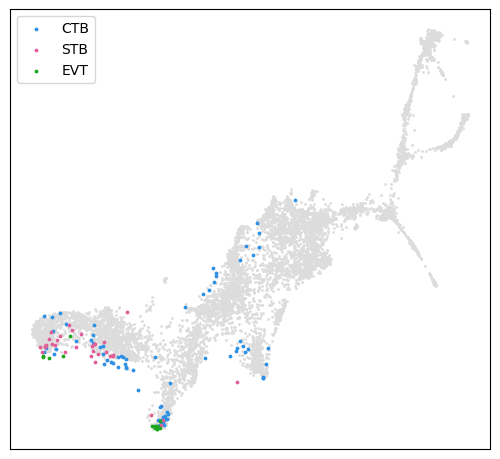

In [87]:
# Plot the results
plt.figure(figsize=(5,5))
#
plt.scatter(ES_UMAP_Embedding[:,0],ES_UMAP_Embedding[:,1],s=1,c="gainsboro")
#
CTB_Inds = np.where(West2019_adata.obs["West_Labels"] == "CTB")[0]
plt.scatter(West2019_Overlay[CTB_Inds,0],West2019_Overlay[CTB_Inds,1],s=3,label="CTB")
STB_Inds = np.where(West2019_adata.obs["West_Labels"] == "STB")[0]
plt.scatter(West2019_Overlay[STB_Inds,0],West2019_Overlay[STB_Inds,1],s=3,label="STB")
EVT_Inds = np.where(West2019_adata.obs["West_Labels"] == "EVT")[0]
plt.scatter(West2019_Overlay[EVT_Inds,0],West2019_Overlay[EVT_Inds,1],s=3,label="EVT")
#
plt.xticks([])
plt.yticks([])
plt.legend()
#
plt.subplots_adjust(0.02,0.02,0.98,0.9)
#
plt.show()

### Save results
Some suggested objects to save for reproducibility (un-comment to use).

In [ ]:
# # The adata object with saved ES arrays
# adata.write_h5ad(path+"ES_adata.h5ad",compression='gzip')
# # The cell UMAP embedding
# np.save(path+"ES_UMAP_Embedding.npy",ES_UMAP_Embedding)
# # The ES-GSS gene set that produced the cell UMAP embedding
# np.save(path+"ES_GSS_Genes.npy",ES_GSS_Genes)
# # The Leiden clusters generated during intentional over-clustering
# np.save(path+"Leiden_Clusts.npy",Leiden_Clusts)
# # The optimised gene set selected by ES-FMG
# Chosen_Genes = np.load(path+"ES_FMG_Marker_Genes.npy")
# # The optimised gene set indices/Max ESS cluster indices selected by ES-FMG
# Chosen_Clusters = np.load(path+"ES_FMG_Chosen_Clusters.npy")